![alt text](img/LM.png)
# Kurs: Deep Learning, Text Mining i XAI w Pythonie

## Autor: Piotr Ćwiakowski

### Lekcja 8. Sieci konwolucyjne (CNN) - ćwiczenia

## Zadanie 1. 
Wytrenuj sieć neuronową (korzystając z gotowych funkcji), która prognozuje fraudy na kartach kredytowych.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/creditcard.csv.zip')
print(df.shape)

print(df['Class'].value_counts())

features = df.columns.tolist()
features.remove('Class')
target = 'Class'

df.head()

(284807, 31)
0    284315
1       492
Name: Class, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


a) przygotuj zbiór (standarazycja zmiennych) i pakiety do budowy sieci neuronowej 

In [3]:
df[features] = df[features].apply(lambda x: (x - x.mean())/x.std())
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996580,-0.694241,-0.044075,1.672771,0.973364,-0.245116,0.347067,0.193679,0.082637,0.331127,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330891,-0.063781,0.244964,0
1,-1.996580,0.608495,0.161176,0.109797,0.316522,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.307376,-0.880075,0.162201,-0.561130,0.320693,0.261069,-0.022256,0.044607,-0.342474,0
2,-1.996558,-0.693499,-0.811576,1.169466,0.268231,-0.364571,1.351451,0.639775,0.207372,-1.378673,...,0.337631,1.063356,1.456317,-1.138090,-0.628536,-0.288446,-0.137137,-0.181021,1.160684,0
3,-1.996558,-0.493324,-0.112169,1.182514,-0.609726,-0.007469,0.936148,0.192070,0.316017,-1.262501,...,-0.147443,0.007267,-0.304776,-1.941024,1.241902,-0.460217,0.155396,0.186188,0.140534,0
4,-1.996537,-0.591329,0.531540,1.021410,0.284655,-0.295015,0.071998,0.479301,-0.226510,0.744325,...,-0.012839,1.100009,-0.220123,0.233250,-0.395201,1.041609,0.543619,0.651815,-0.073403,0


In [3]:
# Podstawowe biblioteki
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Pomocnicze biblioteki
import os
import time
import gc
import pickle
from __future__ import print_function

# Machine Learning
from sklearn.model_selection import train_test_split,StratifiedKFold,KFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# tensorflow/keras
import keras
import tensorflow as tf
from keras import regularizers
from keras.backend import set_session
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.advanced_activations import PReLU
from keras.preprocessing.text import Tokenizer

b) wczytaj wrappery do budowy sieci w pakiecie keras i wykonaj "pierwsze uruchomienie" i przeanalizuj historię uczenia.

In [8]:
# Wydzielona funkcja, która odpowiada wyłącznie za budowę sieci.
def create_network(n=3, nu1=10, nu2=5, nu3=5,
                   activation='relu',
                   dropout=Dropout,
                   dropout_rate=0,
                   regu=0,
                   kernel_initializer='lecun_normal',
                   optimizer='SGD',
                   num_classes=1, 
                   inputShape=10, dropout_all_layers = False, debug=False, *args, **kwargs):
    nu=[nu1, nu2, nu3]
    # Jeżeli włączony jest tryb debug wyświetlimy parametry funkcji
    if debug:
        print(locals())
        
    # Inicjacja podstawowego modelu keras w trybie sekwencyjnym
    # W ten sposób najłatwiej zbutować w pełni połączone sieci feed forward.
    model = Sequential()
    
    # Definicja inputów do sieci oraz pierwszej warstwy
    # nu[0] odpowiada za liczbę neuronów w pierwszej warstwie
    # dodatkowo ustalamy jak inicjalizować parametry raz czy stosować regularyzację.
    model.add(Dense(nu[0],input_shape=(inputShape,),
                    kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(regu)))
    
    # Dodanie funkcji aktywacji do pierwszej warstwy.
    actModel(model, activation)
    
    # Opcjonalne włączenie mechanizmu dropout
    if dropout_rate > 0.01:
        model.add(dropout(dropout_rate))
    
    # Kolejne warstwy budowane są w ten sam sposób, co pozwala budować je w pętli
    # Pierwsza warstwa jako jedyna musiała mieć zdefiniowany input
    # W pozostałych warstwach model automatycznie keras połączy warstwy,
    # Input do kolejnej warstwy będzie outputem z wcześniejszych warstw.
    for i in range(1, n):
        # Inicjalizacja warstwy przez potanie liczby neuronów oraz sposobu inicjacji
        model.add(Dense(nu[i], kernel_initializer=kernel_initializer))
        # Definicja funkcji aktywacji
        actModel(model, activation)
        
        # Opcjonalne dodanie dropout
        if dropout_rate > 0.01 and dropout_all_layers:
            model.add(dropout(dropout_rate))

    # Aby "zakończyć" sieć niezbędne jest przygotowanie odpowiedniej liczby neuronów
    # Wystarczy jeden neuron dla regresji
    # Dla klasyfikacji binarnej oraz wieloklasowej potrzeba tyle neuronów co klas.
    # Dla binarne będą to dwa neurony.
    # W przypadku klasyfikacji wieloklasowej target musi być również podany w postaci one- hot encoding.
    model.add(Dense(num_classes))
    
    # Dla klasyfikacji binarnej lub wieloklasowej jako funkcję aktywacji stosujemy softmax
    # Będzie on odpowiadał transformacji logistycznej.
    # W problemie regresji możemy po prostu wykorzystać funkcję liniową.
    # Na chwilę obecną budujemy wrapper dla klasyfikacji binarnej
    # Poniżej pozostawiamy softmax, z funkcją straty categorical_crossentropy oraz accuracy jak bazową metryką.
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [9]:
# Funkcja pomocnicza,która pozwoli nam również zaawansowane funkcje aktywacji wybierać po imieniu
def actModel(model, activation):
    if activation=='prelu':
        model.add(PReLU(weights=None, alpha_initializer="zero"))
    else:
        model.add(Activation(activation))
    return

In [6]:
# Funkcja net będzie naszym wrapperem do budowania siecie, trenowania, oraz zbierania wyników/statystyk.
def net(train, test, features, target, epochs = 30, batchSize=100, debug=False, *args, **kwargs):
    
    # Przygotowanie zmiennych
    y_train = tf.keras.utils.to_categorical(train[target].values)
    y_test = tf.keras.utils.to_categorical(test[target].values)
    x_train = train[features].values
    x_test = test[features].values
    
    num_classes = y_train.shape[1]
    
    # Wyświetlenie informacji opisowych jeżeli jesteśmy w trybie debugowym
    if debug:
        print('Loading data...')
        print(len(x_train), 'train sequences')
        print(len(x_test), 'test sequences')
        print(num_classes, 'classes')
        print('x_train shape:', x_train.shape)
        print('x_test shape:', x_test.shape)
        print('\nBuilding network 1...')
    
    # Stworzenie modelu z użyciem funkcji create_network.
    model = create_network(num_classes=num_classes, inputShape=x_train.shape[1], debug=debug, *args, **kwargs)
    
    # Przygotowanie zmiennych do przechowywania statystyk dotyczących szkolenia
    history_model = dict()
    loss = []
    valLoss = []
    acc = []
    valAcc = []
    auc = []
    valAuc = []
    
    
    bestTrainProba = []
    bestTestProba = []
    bestAuc = 0
    # Iteracyjne uruchomienie szkolenia.
    # UWAGA! W "profesjonalnym" wykorzystaniu Kerasa stosuje się tzw. callbacki, 
    # callbacki to funkcje do uruchamiania pomiędzy iteracjami.
    # W naszej dydaktycznej implementacji sami będziemy iterować szkolenie w pętli po jednej iteracji
    for z in range(epochs):
        # Wykonaj jedną ideacje szkolenia
        histModel = model.fit(x_train,
                              y_train,
                              batch_size=batchSize,
                              epochs=1,
                              verbose=debug,
                              validation_split=0.0,
                              validation_data=(x_test, y_test))
        # Zrób prognoze na zbiorze treningowym
        probaTrain = model.predict(x_train,
                                   batch_size=y_train.shape[0],
                                   verbose=debug)
        # Zrób prognozę na zbiorze testowym
        probaTest = model.predict(x_test,
                                  batch_size=y_test.shape[0],
                                  verbose=debug)
        # Obliczenie statystyk AUC
        # We wcześniejszych wersjach Keras nie miał wbudowanego liczenia auc pomiędzy iteracjami
        aucTrain = roc_auc_score(train[target], probaTrain[:,1])
        aucTest = roc_auc_score(test[target], probaTest[:,1])
        if debug:
            print(aucTrain, aucTest)
            
        # Ręczna implementacja zapisywania prognoz z najlepszej iteracji
        if aucTest>bestAuc:
            bestAuc = aucTest
            bestTrainProba = probaTrain[:, 1].tolist()
            bestTestProba = probaTest[:, 1].tolist()
        
        # Zapisanie wyników w tej iteracji
        loss.append(histModel.history['loss'][0])
        valLoss.append(histModel.history['val_loss'][0])
        auc.append(aucTrain)
        valAuc.append(aucTest)
        
    # Zapisanie wyników ze wszystkich iteracji do słownika
    history_model['loss'] = loss
    history_model['valLoss'] = valLoss
    history_model['auc'] = auc
    history_model['valAuc'] = valAuc
    return max(valAuc), bestTrainProba, bestTestProba, history_model

In [11]:
test_size=0.3
X_train, X_valid = train_test_split(df, test_size=test_size, random_state=2020, stratify=df[target].values)
score, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features, target, n=2, nu1=400, nu2=100,
                                                    epochs = 30, batchSize=500, debug=True)
print(score)


Loading data...
199364 train sequences
85443 test sequences
2 classes
x_train shape: (199364, 30)
x_test shape: (85443, 30)

Building network 1...
{'n': 2, 'nu1': 400, 'nu2': 100, 'nu3': 5, 'activation': 'relu', 'dropout': <class 'keras.layers.core.dropout.Dropout'>, 'dropout_rate': 0, 'regu': 0, 'kernel_initializer': 'lecun_normal', 'optimizer': 'SGD', 'num_classes': 2, 'inputShape': 30, 'dropout_all_layers': False, 'debug': True, 'args': (), 'kwargs': {}, 'nu': [400, 100, 5]}
1/1 [==============================] - 0s 147ms/step
0.696832860376309 0.7112031692868788
1/1 [==============================] - 0s 114ms/step
0.7855552161989097 0.7817677282182822
1/1 [==============================] - 0s 117ms/step
0.8170937229050252 0.8240848137544896
1/1 [==============================] - 0s 107ms/step
0.825004688672168 0.8361924354743394
1/1 [==============================] - 0s 107ms/step
0.8391433576852156 0.8464505539597866
1/1 [==============================] - 0s 106ms/step
0.845992762

0.9622531817238424


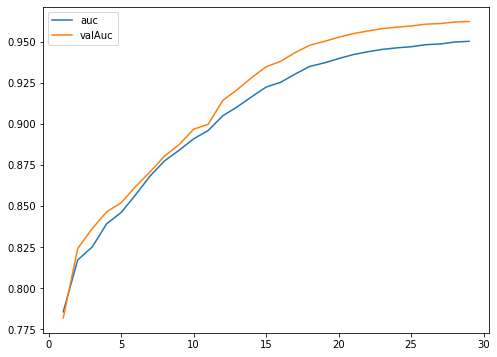

In [12]:
history = pd.DataFrame(history)
print(history.valAuc.max())
history.loc[1:, ["auc", "valAuc"]].plot(figsize=(8,6))
plt.show()

c) przejrzyj najważniejsze hiperparametry sieci.

SGD 0.9250684032998353
RMSprop 0.9850671675251076
Adagrad 0.8006255317396065
Adadelta 0.40441666679869387
Adam 0.9826520597037626
Adamax 0.9828811929345372


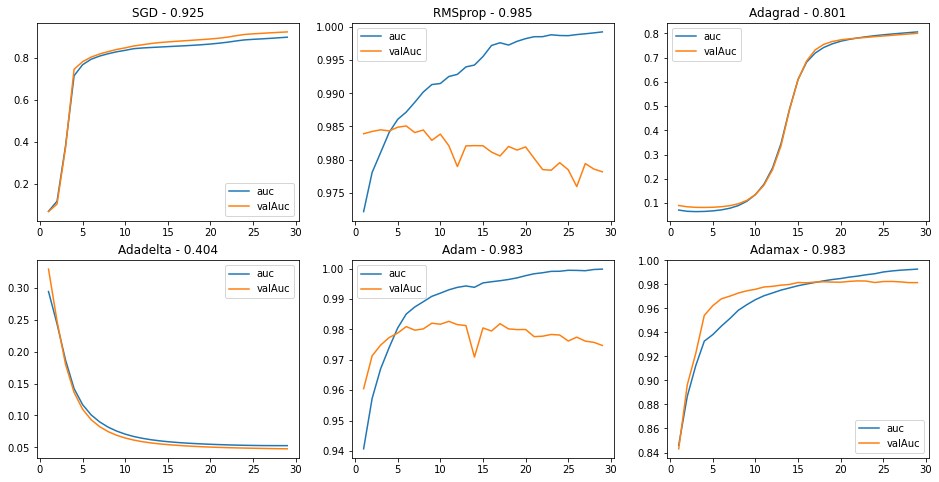

In [14]:
# Lista optimizerów które będziemy sprawdzać
opti = ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax"]


fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()

# konfiguracja 1.
n = 2
nu1 = 100
nu2 = 40
nu3 = 10

for i, opt in enumerate(opti):
    score, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features, target, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 30, batchSize=1000, optimizer=opt, debug=False)
    print(opt, score)
    history = pd.DataFrame(history)
    history.loc[1:, ["auc", "valAuc"]].plot(ax = ax[i])
    ax[i].set_title(opt+ " - " + str(round(score, 3)))
    gc.collect()

tanh 0.9883723500157641
sigmoid 0.9893161729641007
linear 0.9841435051324259
relu 0.9809811892905861
selu 0.9920805851868634
prelu 0.988640932978233


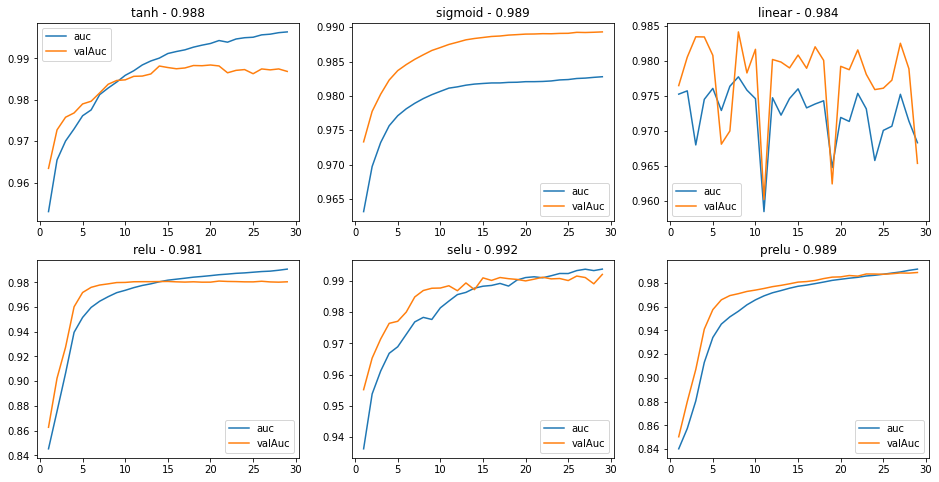

In [17]:
# Lista sprawdzanych funkcji
activations = ["tanh", "sigmoid", "linear", "relu", "selu", "prelu"]

fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()

# Konfiguracja 1.
n = 2
nu1 = 100
nu2 = 40
nu3 = 10

for i, acti in enumerate(activations):
    score, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features, target, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 30, batchSize=1000, optimizer="Adamax", activation=acti, debug=False)
    print(acti, score)
    history = pd.DataFrame(history)
    history.loc[1:, ["auc", "valAuc"]].plot(ax = ax[i])
    ax[i].set_title(str(acti)+ " - " + str(round(score, 3)))
    gc.collect()

0 0.9862573136475475
0.001 0.9920881107380902
0.05 0.9892858331102073
0.1 0.9880631290766703
0.2 0.9871615680396969
0.5 0.9867768143311845


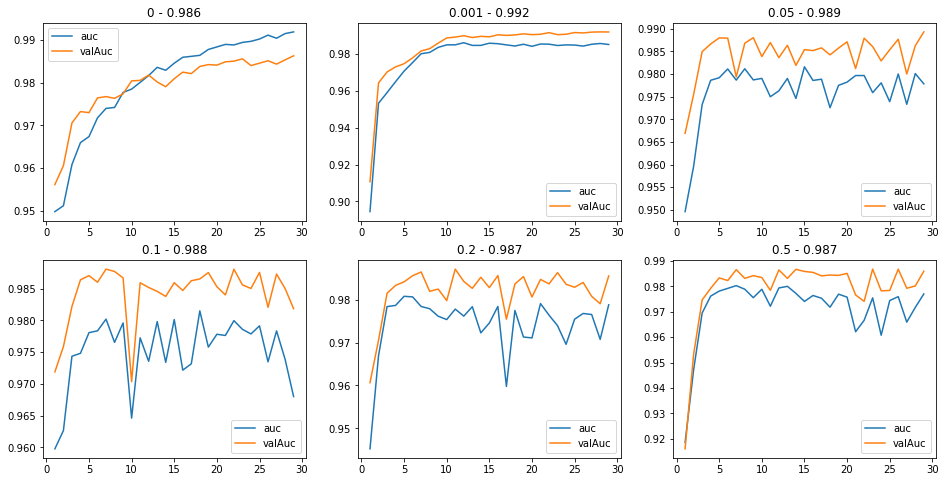

In [18]:
reguRates = [0, 0.001, 0.05, 0.1, 0.2, 0.5]

fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()
n = 2
nu1 = 100
nu2 = 40
nu3 = 10

for i, reguRate in enumerate(reguRates):
    score, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features, target, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 30, batchSize=1000, optimizer="Adamax", activation="selu",
                                     regu=reguRate, debug=False)
    print(reguRate, score)
    history = pd.DataFrame(history)
    history.loc[1:, ["auc", "valAuc"]].plot(ax = ax[i])
    ax[i].set_title(str(reguRate)+ " - " + str(round(score, 3)))
    gc.collect()

0 0.9924814198101026
0.2 0.9857793223201512
0.4 0.9835542148632013
0.5 0.9905201819440638
0.6 0.986534966879653
0.8 0.9787512100294209


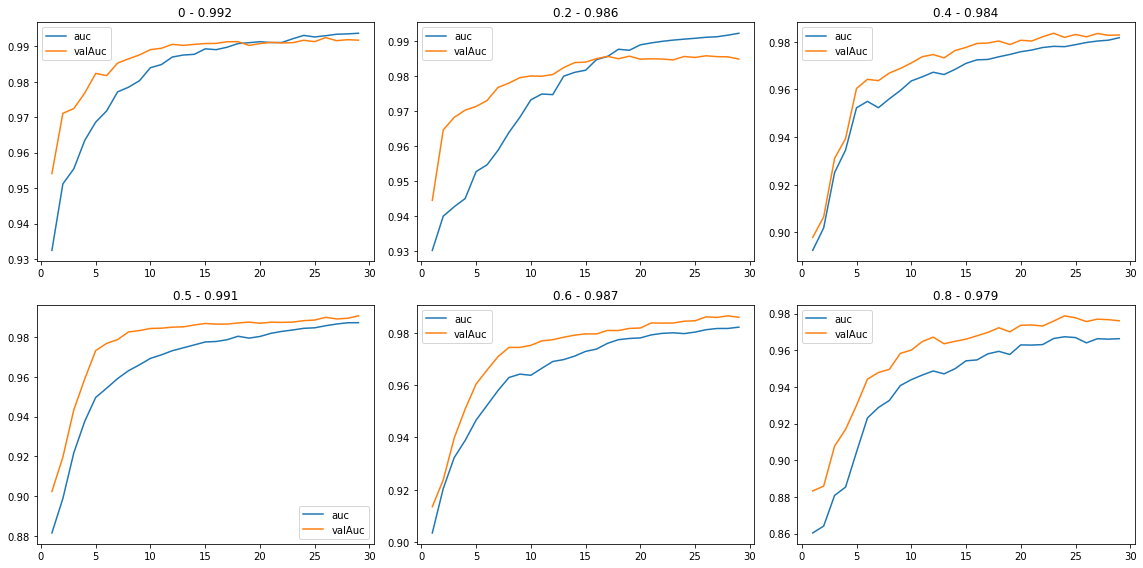

In [19]:
# Sprawdzane poziomy dropout
dropRates = [0, 0.2, 0.4, 0.5, 0.6, 0.8]

fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()
n = 2
nu1 = 100
nu2 = 40
nu3 = 10

for i, dropRate in enumerate(dropRates):
    score, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features, target, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 30, batchSize=1000, optimizer="Adamax", activation="selu",
                                    dropout_rate=dropRate, debug=False)
    print(dropRate, score)
    history = pd.DataFrame(history)
    history.loc[1:, ["auc", "valAuc"]].plot(ax = ax[i])
    ax[i].set_title(str(dropRate)+ " - " + str(round(score, 3)))
    gc.collect()

plt.tight_layout()
fig.savefig(f"imgNets/dropRate_{n}_{nu1}_{nu2}_{nu3}.png")
plt.show()

d) dla kilku wybranych modeli przeprowadź walidację krzyżową.

## Zadanie 2.

a) Wczytaj dane MNIST.

In [1]:
# Wczytanie danych
from keras.datasets import mnist
from keras.utils.all_utils import to_categorical 
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

b) przeanalizuj zmienną objaśnianą i wyświetl kilka przykładowych obrazów.

In [4]:
# Rozkład poszczególnych kategorii w zbiorze treningowym i testowy.
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print("\nTest labels: ", dict(zip(unique, counts)))

Train labels:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}

Test labels:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


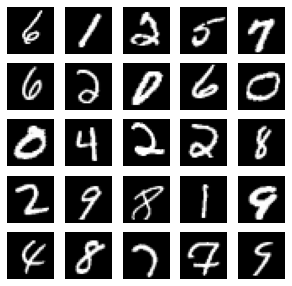

In [5]:
# Wylosowanie 25 obserwacji
ind = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[ind]

# Wygenerowanie obrazów
plt.figure(figsize=(5,5))
for i in range(len(ind)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    
plt.show()

c) Przygotuj zbiór do budowy sieci MLP do zadania klasyfikacji wielotykietowej:

In [6]:
y_train[:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=uint8)

In [7]:
# Policzmy liczbę kategorii
num_labels = len(np.unique(y_train))

# Zmienna objaśniana musi być w formacie one-hot-encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [8]:
y_train[:20, :]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [9]:
# Zbiór X jest tensorem 2D, trzeba go spłaszczyć:

# Wymiary obrazu:
input_size = x_train.shape[1] * x_train.shape[1]

# Zmiana kształtu i normalizacja
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

x_train.shape, x_test.shape

((60000, 784), (10000, 784))

c) zbuduj (od podstaw, bez walidacji krzyżowej) sieć MLP która wykrywa/prognozuje cyfry ze zbioru MNIST o następującej architekturze:
* warstwę głęboką z 512 neuronami i aktywacją "relu" (`Dense`),
* warstwę dropout z 20% drop rate (`Dropout`),
* warstwę głęboką z 512 neuronami i aktywacją "relu" (`Dense`),
* warstwę dropout z 20% drop rate (`Dropout`),
* warstwę głęboką będącą outputem (ile neuronów i jakiej aktywacji powinieneś użyć?).

In [10]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(rate = .2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate = .2))
model.add(Dense(10, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


d) Skompiluj model używając SGD jako optimizera, wybierz odpowiednią funkcję straty. Dodatkowo pokaż "accuracy" jako metrykę. 

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

e) Dopasuj model. Użyj 20% zbioru do walidacji. Trenuj model przez 20 epok z batch'em wielkości 128 obserwacji. Jeśli potrafisz, przedstaw historię uczenia na wykresie.

In [13]:
histModel = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=True, validation_split=0.2, validation_data=(x_test, y_test))

Epoch 1/20
375/375 [==============================] - 3s 9ms/step - loss: 1.3274 - accuracy: 0.6569 - val_loss: 0.6152 - val_accuracy: 0.8632
Epoch 2/20
375/375 [==============================] - 3s 8ms/step - loss: 0.5976 - accuracy: 0.8330 - val_loss: 0.4062 - val_accuracy: 0.8949
Epoch 3/20
375/375 [==============================] - 3s 8ms/step - loss: 0.4667 - accuracy: 0.8665 - val_loss: 0.3454 - val_accuracy: 0.9061
Epoch 4/20
375/375 [==============================] - 3s 8ms/step - loss: 0.4104 - accuracy: 0.8816 - val_loss: 0.3138 - val_accuracy: 0.9112
Epoch 5/20
375/375 [==============================] - 3s 8ms/step - loss: 0.3746 - accuracy: 0.8916 - val_loss: 0.2895 - val_accuracy: 0.9182
Epoch 6/20
375/375 [==============================] - 3s 8ms/step - loss: 0.3505 - accuracy: 0.8986 - val_loss: 0.2726 - val_accuracy: 0.9215
Epoch 7/20
375/375 [==============================] - 3s 8ms/step - loss: 0.3252 - accuracy: 0.9059 - val_loss: 0.2585 - val_accuracy: 0.9252
Epoch 

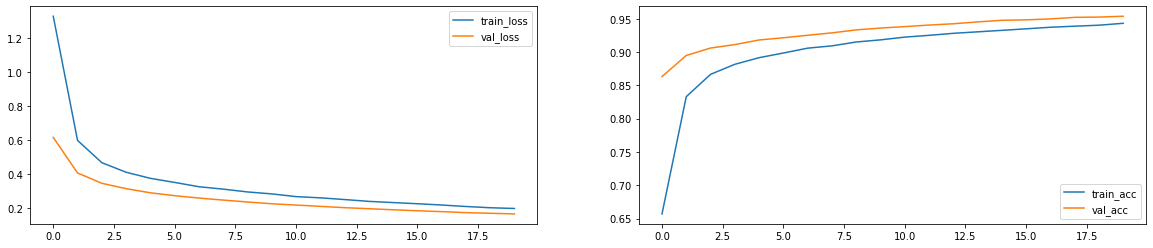

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (20, 4))

ax[0].plot(histModel.epoch, histModel.history['loss'], label='train_loss')
ax[0].plot(histModel.epoch, histModel.history['val_loss'], label='val_loss')
# ax[0].set_xlabel(np.arange(0, 20))
ax[0].legend()

ax[1].plot(histModel.epoch, histModel.history['accuracy'], label='train_acc')
ax[1].plot(histModel.epoch, histModel.history['val_accuracy'], label='val_acc')
# ax[1].set_xlabel(list(range(0, 20)))
ax[1].legend();

f) Ewaluacja na zbiorze testowym i oblicz predykcję dla zbioru testowego.

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

313/313 [==============================] - 1s 2ms/step - loss: 0.1650 - accuracy: 0.9517
Test accuracy 0.95169997215271
Test loss 0.1650310605764389


g) napisz funkcje, która przeprowadza trenowanie i ewaluację skompilowanego modelu: 

In [28]:
def net_learning(model, x_train, y_train, x_test, y_test, batch_size=128, epochs=20, verbose=True, validation_split=0.2):
    '''model - skompilowany model keras/tensorflow'''
    histModel = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, 
                          validation_split=validation_split, validation_data=(x_test, y_test))
                 
    fig, ax = plt.subplots(1, 2, figsize = (20, 4))

    ax[0].plot(histModel.epoch, histModel.history['loss'], label='train_loss')
    ax[0].plot(histModel.epoch, histModel.history['val_loss'], label='val_loss')
    # ax[0].set_xlabel(np.arange(0, 20))
    ax[0].legend()

    ax[1].plot(histModel.epoch, histModel.history['accuracy'], label='train_acc')
    ax[1].plot(histModel.epoch, histModel.history['val_accuracy'], label='val_acc')
    # ax[1].set_xlabel(list(range(0, 20)))
    ax[1].legend();
                 
    test_loss, test_acc = model.evaluate(x_test, y_test)

    print("Test accuracy", test_acc)
    print("Test loss", test_loss)
    
    return histModel, test_loss, test_acc

Epoch 1/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1924 - accuracy: 0.9436 - val_loss: 0.1609 - val_accuracy: 0.9556
Epoch 2/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1880 - accuracy: 0.9449 - val_loss: 0.1571 - val_accuracy: 0.9558
Epoch 3/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1822 - accuracy: 0.9481 - val_loss: 0.1539 - val_accuracy: 0.9563
Epoch 4/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1770 - accuracy: 0.9491 - val_loss: 0.1502 - val_accuracy: 0.9574
Epoch 5/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1740 - accuracy: 0.9489 - val_loss: 0.1471 - val_accuracy: 0.9589
Epoch 6/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1699 - accuracy: 0.9516 - val_loss: 0.1441 - val_accuracy: 0.9592
Epoch 7/20
375/375 [==============================] - 3s 9ms/step - loss: 0.1642 - accuracy: 0.9528 - val_loss: 0.1413 - val_accuracy: 0.9603
Epoch 

(<keras.callbacks.History at 0x2522b9e15b0>,
 0.11087790876626968,
 0.9646999835968018,
 <Figure size 1440x288 with 2 Axes>)

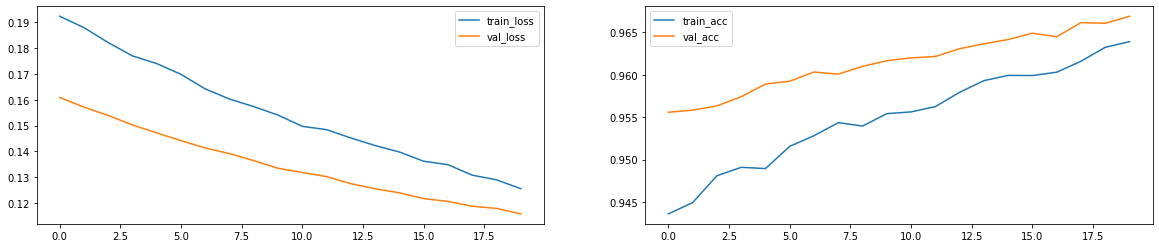

In [29]:
histModel, test_loss, test_acc = net_learning(model, x_train, y_train, x_test, y_test)

g) Zaproponuj kilka innych architektur sieci:

- z 3 warstwami,
- z rózną liczbą perceptronów,
- z regularyzacją,

I sprawdź jak wpływa to na wynik i na proces uczenia.

In [31]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,), kernel_regularizer=regularizers.l2(.5)))
model.add(Dropout(rate = .2))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.5)))
model.add(Dropout(rate = .2))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.5)))
model.add(Dropout(rate = .2))
model.add(Dense(10, activation='softmax'))

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               401920    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 10)               

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

In [ ]:
histModel, test_loss, test_acc = net_learning(model, x_train, y_train, x_test, y_test)